In [0]:
!wget http://aqua.cs.uiuc.edu/cleaned_training.tar.gz
!tar -xvzf cleaned_training.tar.gz
!mv cleaned_training/data/Our_train/*.png .

In [3]:
from google.colab import files
fl = files.upload()

Saving shadowimage.jpg to shadowimage.jpg
Saving shadowimage2.png to shadowimage2.png
Saving shadowimage3.png to shadowimage3.png
Saving shadowimage4.png to shadowimage4.png
Saving shadowimage5.png to shadowimage5.png
Saving shadowimage6.png to shadowimage6.png


In [0]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from skimage import io
#from skimage.color import rgb2grey
from skimage.transform import resize, rescale
from skimage.filters import gaussian
from scipy.spatial.distance import cosine
from skimage.restoration import denoise_bilateral
import skimage.morphology as morph
from skimage import color

import scipy.spatial

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

Filename|Initial Point|Shadow Seed|Cosine Valley|`filteredImage`-luma|
-|-|-|
`shadowimage.jpg`  | (100,120)| Good (1302)| 1.79143065e-02|5
`shadowimage3.png`| (150,170)| Good| 0.44572278e-02|0
`shadowimage4.png`| (90,155)| Not Good (4)| 0.49966229e-02|0
`shadowimage5.png`| (350,55)| Good (1995)| 2.39143065e-02|Hanging out
`shadowimage6.png`| (130,55)| Good (9375)| 3.26828561e-02|8
`1.png`|(80,110) [0.25]
`2.png`|(80,70) ''
`3.png`| 
`6.png`|(75,85)
`8.png`|(55,105)


# Generating Masks

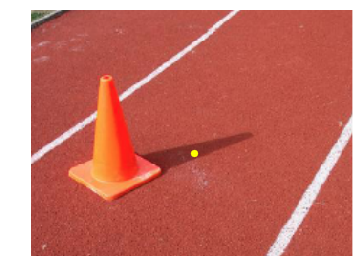

In [5]:
originalImage = io.imread('shadowimage3.png')[:,:,:3]
#originalImage = rescale(originalImage, (0.25,0.25))

imx, imy, _ = originalImage.shape

startPoint = (150,170)

# Plotting/Displaying aspect
io.imshow(originalImage)
plt.scatter(startPoint[1],startPoint[0],color="yellow")
plt.axis('off')
plt.show()

### Generating Shadow Seed

Possible Issues:
  - Seed might not be accurate, might require downsampling for large images
  - Change filter to bilateral filter later

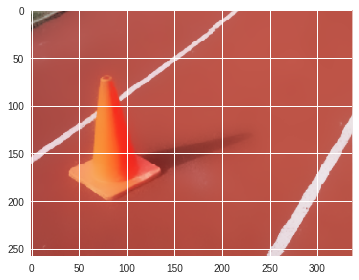

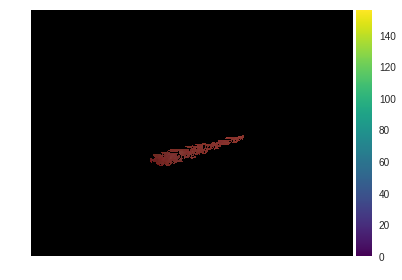

In [6]:
import queue
Q = queue.Queue(1024)
Q.put((startPoint,0))

#before .06, .04
useImage = np.uint8(255 * denoise_bilateral(originalImage,sigma_color=.06,
                                  sigma_spatial=8,multichannel=True))

io.imshow(useImage)
plt.show()

neighbours = [(1,0),(-1,0),(0,1),(0,-1)]
iterations = 100
finMask = np.zeros(useImage.shape[0:2])
# useImage to originalImage
colList = np.array(useImage[startPoint])[np.newaxis,:]

while not Q.empty():
  cur, lev = Q.get()
  for i in neighbours:
    x,y = (cur[0] + i[0], cur[1] + i[1])
    if x<0 or x>=imx or y<0 or y>=imy or finMask[x,y] != 0:
      continue
    
    score = useImage[cur] - useImage[x,y]
    score = np.sum(score ** 2)
    
    if score < 4:
      finMask[x,y] = 1
      if lev < iterations:
        Q.put(((x,y), lev+1))
        # useImage to originalImage
        curCol = (useImage[x,y])[np.newaxis,:]
        colList = np.concatenate((colList, curCol), axis=0)
    else:
      finMask[x,y] = 2
      
finMask[finMask==2] = 0
median = np.median(colList, axis=0)

# Plotting/Displaying aspect
newImage = np.array(originalImage)
for i in range(3):
  newImage[:,:,i] = finMask * originalImage[:,:,i]

plt.axis('off')
io.imshow(newImage[:,:,])
plt.savefig('2.png',dpi=100)
plt.show()

#### Closing shadow seed

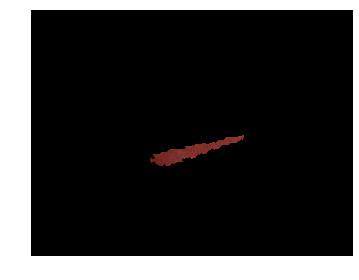

In [8]:
disk = morph.disk(1)
finMaskEroded = morph.binary_closing(finMask, disk)

median = np.zeros((3))
for i in range(3):
  median[i] = np.median(useImage[:,:,i][finMaskEroded==1])

# Plotting/Displaying aspect
newImage = np.array(useImage)
for i in range(3):
  newImage[:,:,i] = finMaskEroded * originalImage[:,:,i]

plt.axis('off')
io.imshow(newImage)
plt.savefig('1.png',dpi=100)
plt.show()

### Find same surface of shadowed region

Possible Issues:
  - Way to find the valley.
  - Uncomment bilateral filteral
  - Vectorize the `cosineImage` construction

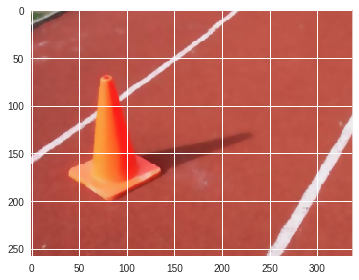

(array([77550,  3504,   911,   824,  1031,   512,  1057,  1378,   157,
          22]), array([3.71487525e-08, 1.39284721e-02, 2.78569070e-02, 4.17853419e-02,
       5.57137769e-02, 6.96422118e-02, 8.35706467e-02, 9.74990817e-02,
       1.11427517e-01, 1.25355952e-01, 1.39284386e-01]))


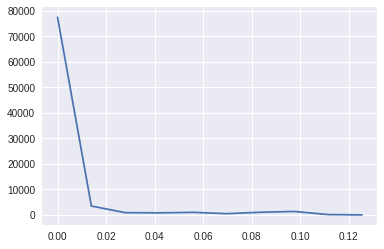

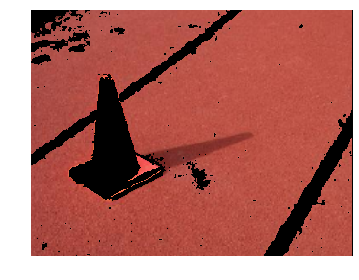

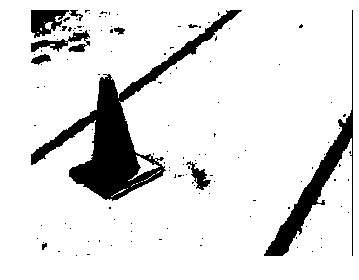

In [11]:
cosineImage = np.zeros(originalImage.shape[0:2])
# before 0.01
filteredImage = denoise_bilateral(originalImage,sigma_color=0.04,
                                  sigma_spatial=2,multichannel=True)

io.imshow(filteredImage)
plt.show()

for i in range(imx):
  for j in range(imy):
    cosineImage[i,j] = np.abs(cosine(originalImage[i,j],median))    

#coslist = np.sort(cosineImage.ravel())
#plt.plot(coslist,np.arange(coslist.shape[0]))
#plt.show()

nhist = np.histogram(cosineImage.ravel())
print(nhist)
plt.plot(nhist[1][:10],nhist[0])
plt.show()

oldCosineImage = np.array(cosineImage)

#threshold to find:
thresh = 0.44572278e-02
cosineImage[cosineImage < thresh] = 1
cosineImage[cosineImage != 1] = 0

# Plotting/Displaying aspect
newImage = np.array(originalImage)
for i in range(3):
  newImage[:,:,i] = cosineImage * originalImage[:,:,i]

plt.axis('off')
io.imshow(newImage,vmin=0,vmax=1)
plt.show()

plt.axis('off')
io.imshow(cosineImage)
plt.show()

### Computing $M_s$ and $M_l$

Possible Issues

- Do with CbCr also

---

`cosineImage`: Mask for surface (shadowed and unshadowed)

`finMask`:  Shadow seed

`finMaskEroded`:  Eroded shadow seed

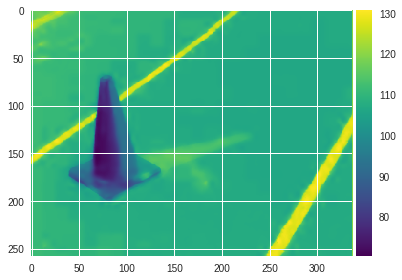

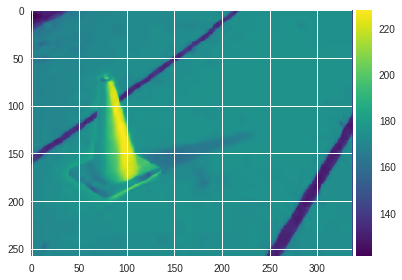

Added none


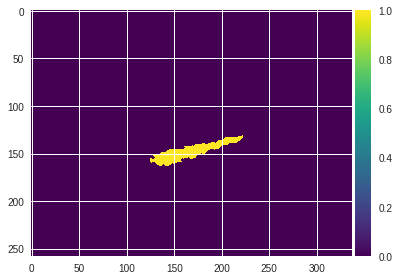

Added none


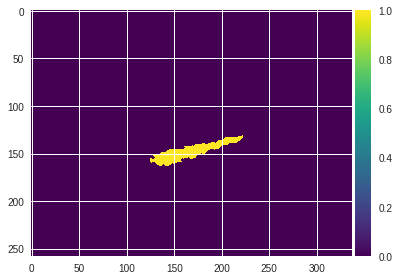

Added none


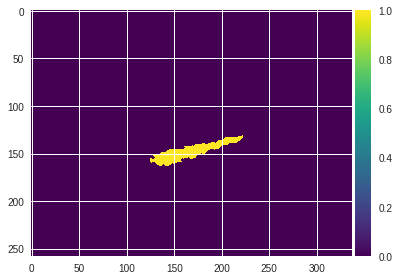

Added none


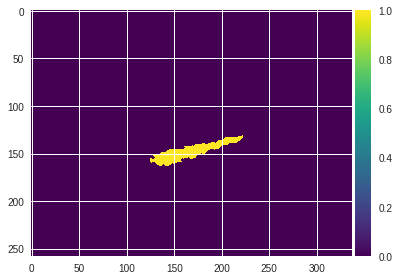

Added none


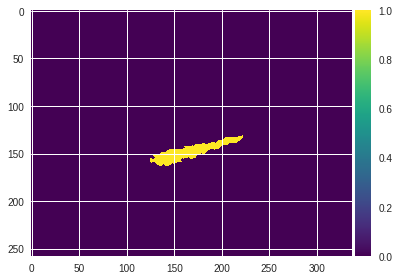

Added none


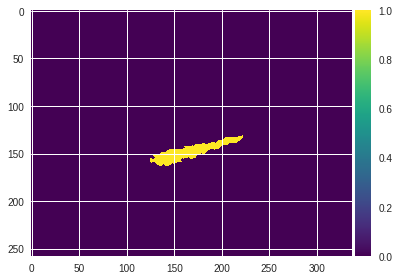

Added none


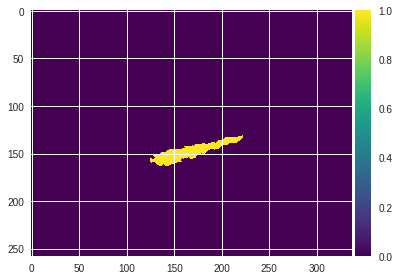

Added none


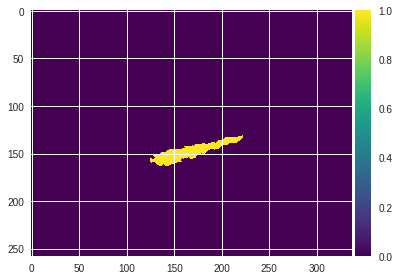

Added none


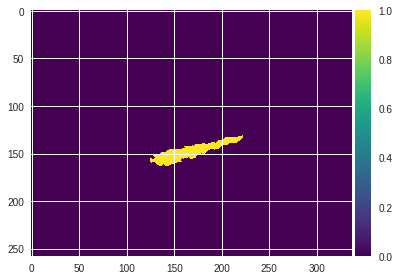

Added none


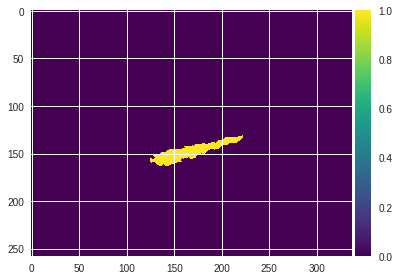

Added none


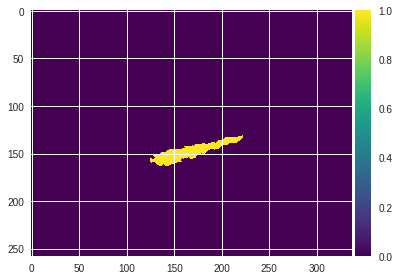

Added none


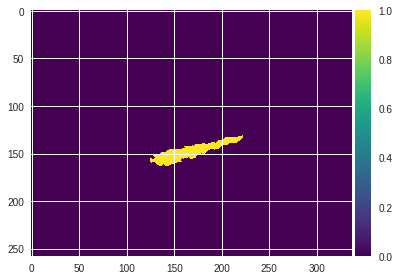

Added none


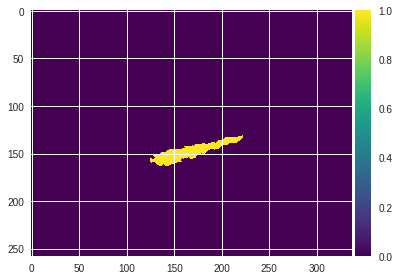

Added none


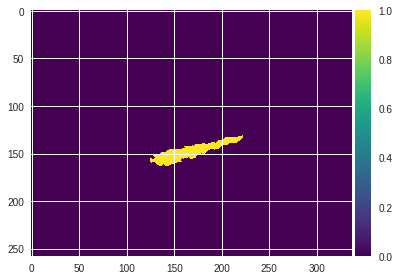

Added none


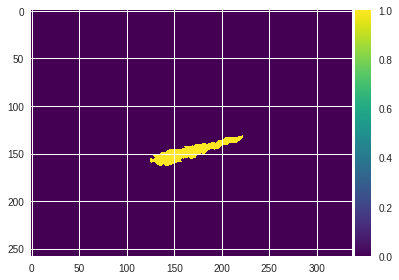

Added none


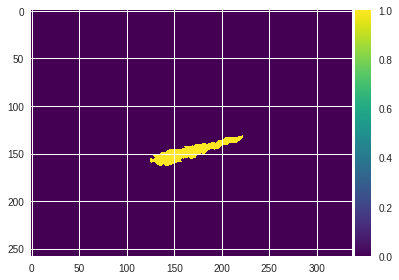

Added none


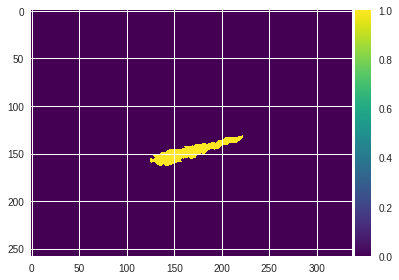

Added none


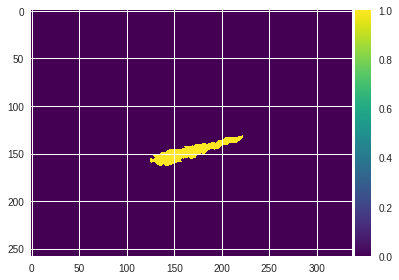

Added none


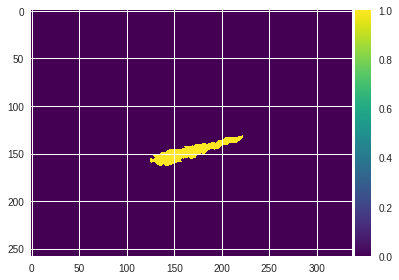

Added none


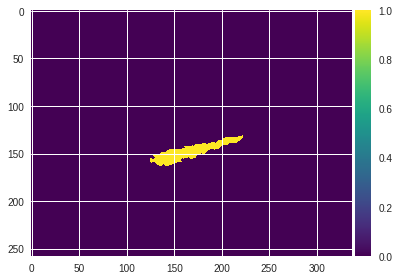

Added none


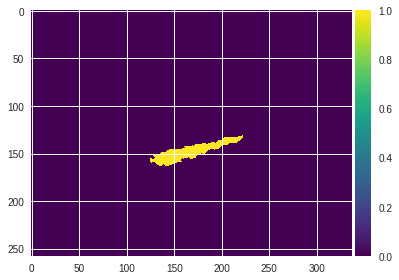

Added none


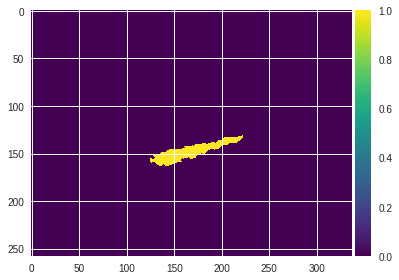

Added none


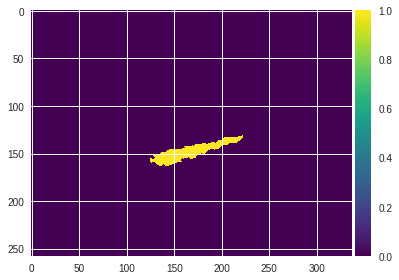

Added none


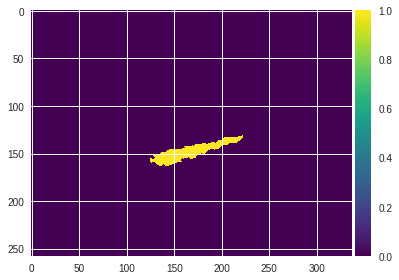

Added none


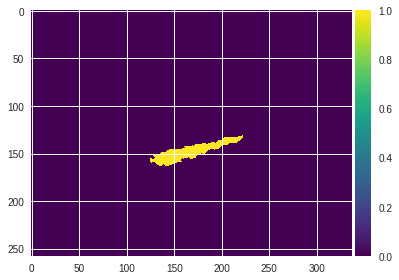

Added none


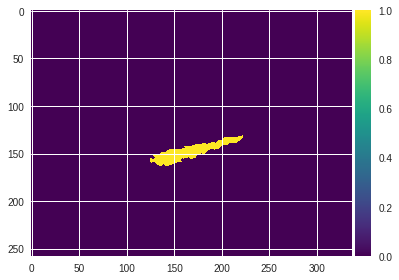

Added none


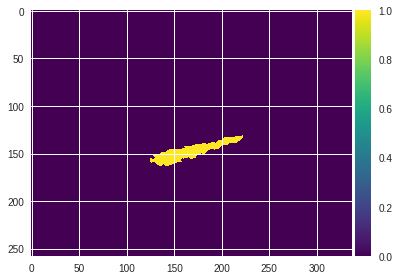

Added none


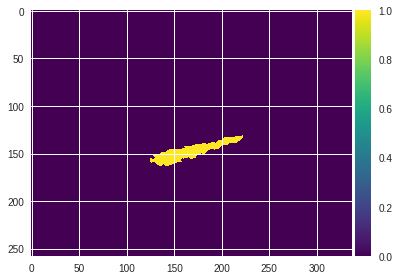

Added none


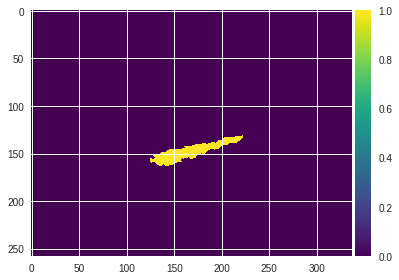

Added none


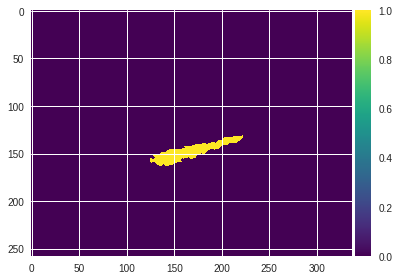

Added none


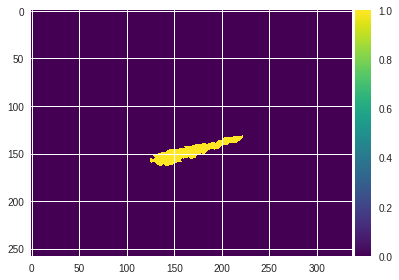

Added none


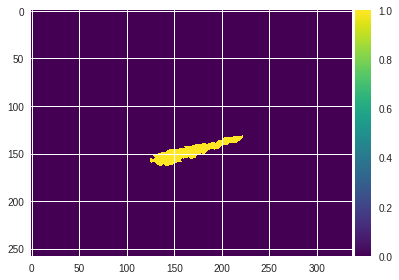

Added none


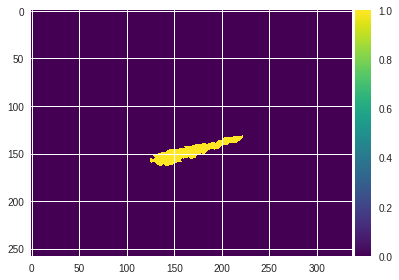

Added none


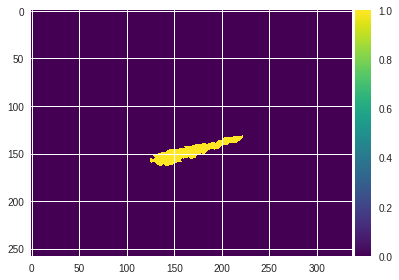

Added none


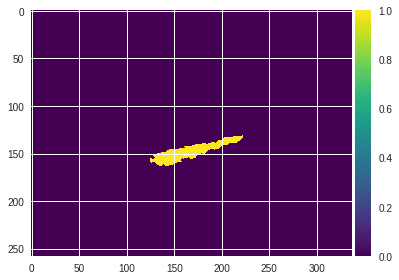

Added none


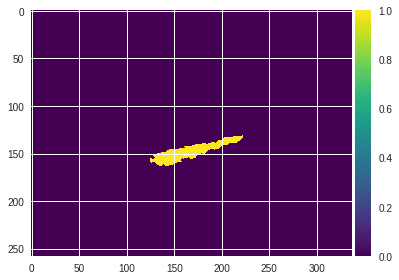

Added none


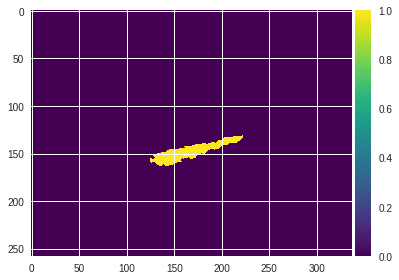

Added none


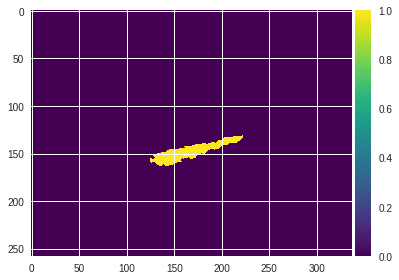

Added none


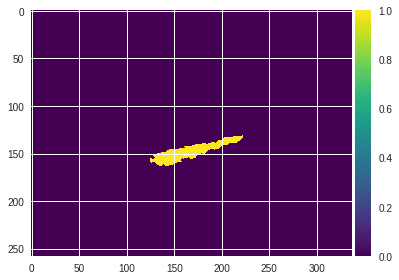

Added none


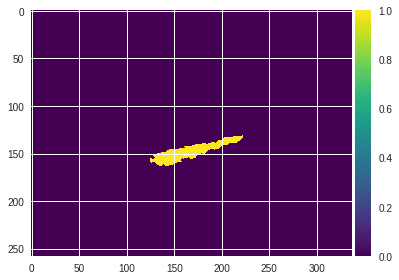

Added none


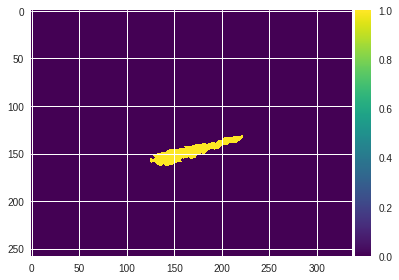

Added none


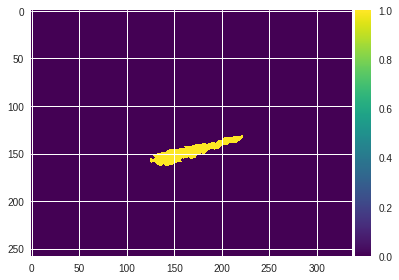

Added none


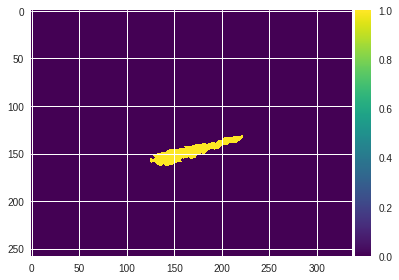

Added none


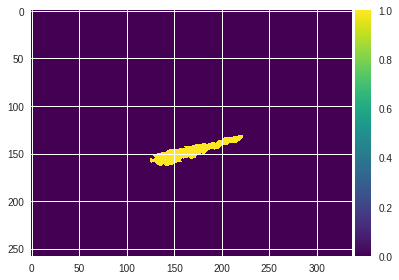

Added none


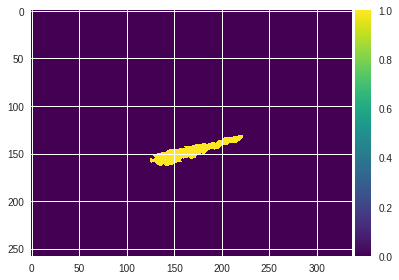

Added none


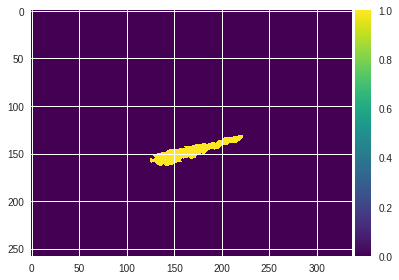

Added none


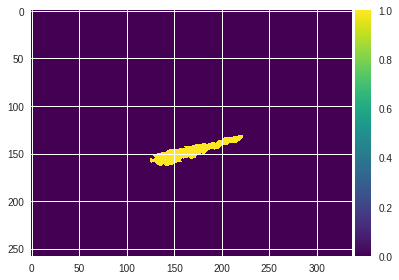

Added none


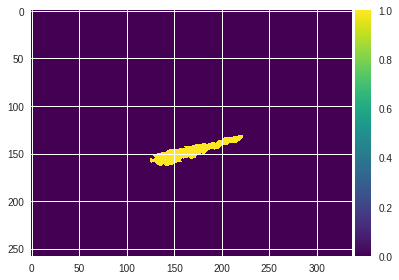

Added none


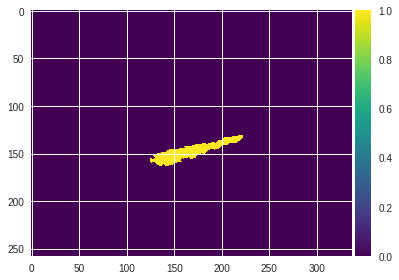

Added none


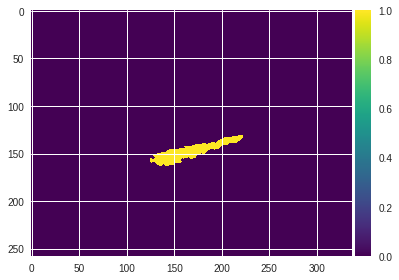

Added none


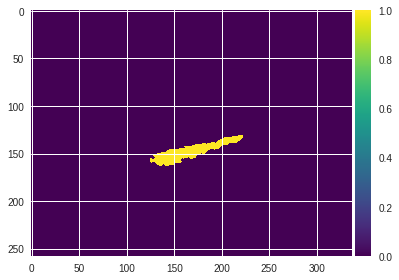

Added none


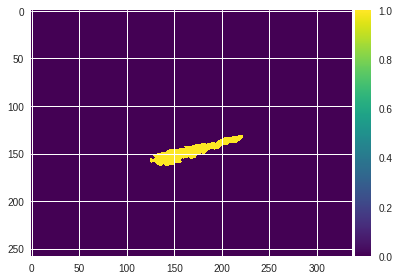

Added none


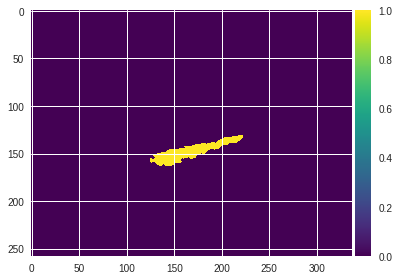

Added none


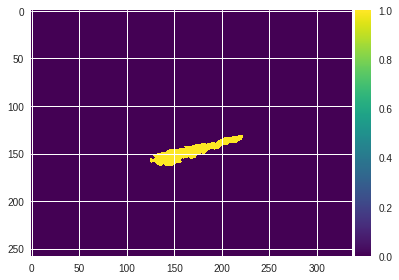

Added none


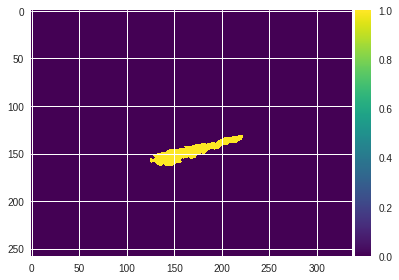

Added none


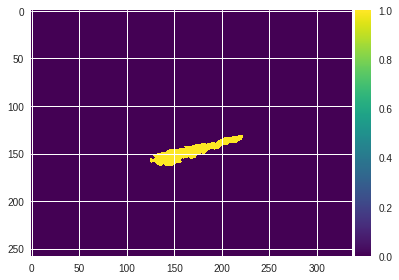

Added none


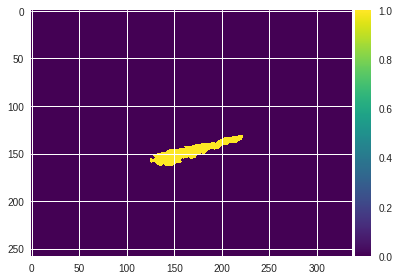

Added none


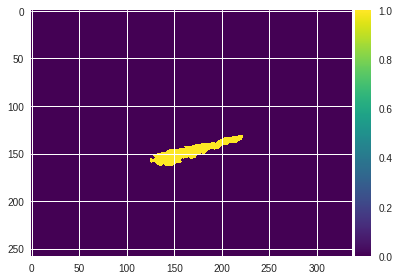

Added none


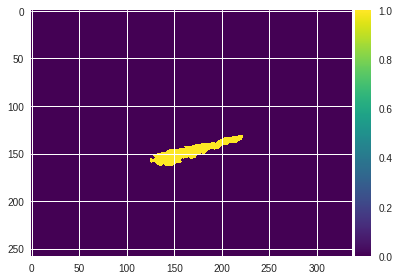

Added none


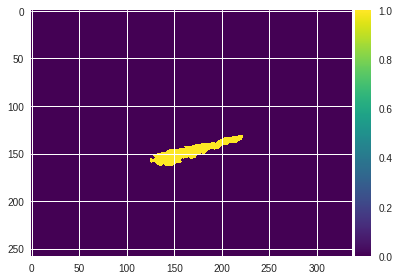

Added none


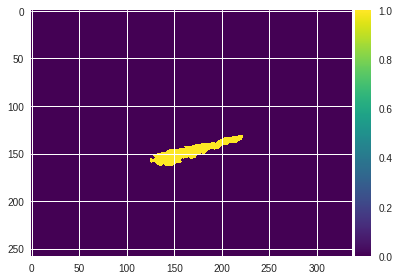

Added none


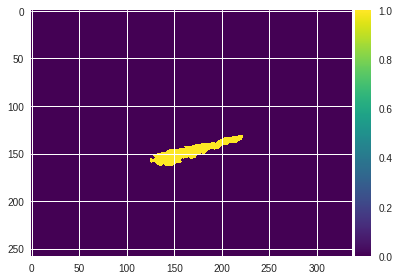

Added none


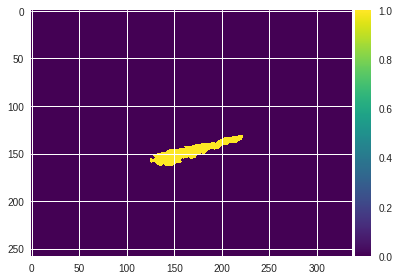

Added none


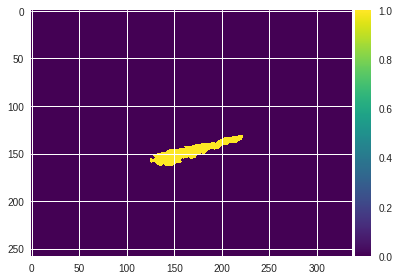

Added none


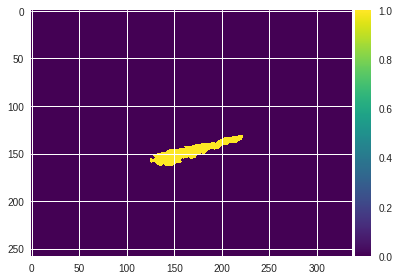

Added none


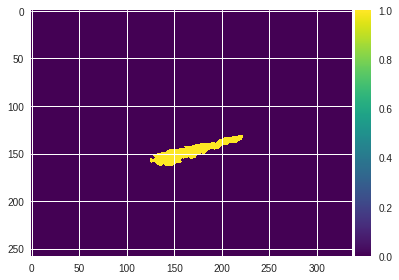

Added none


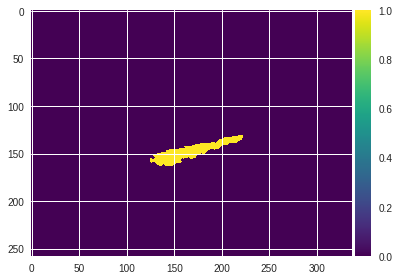

Added none


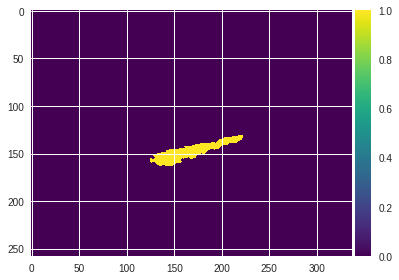

Added none


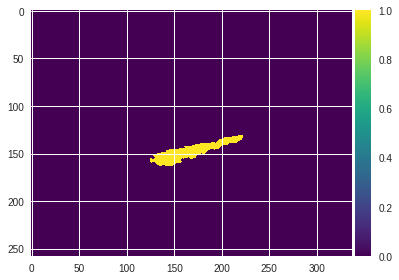

Added none


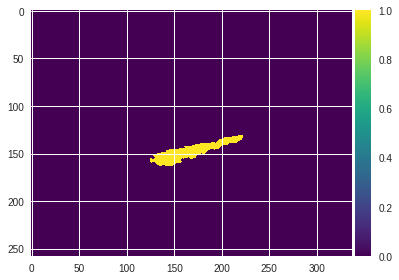

Added none


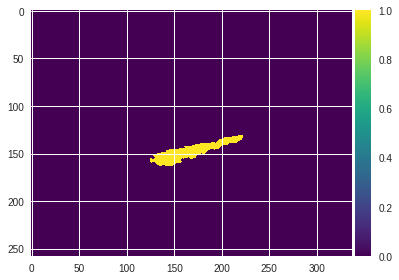

Added none


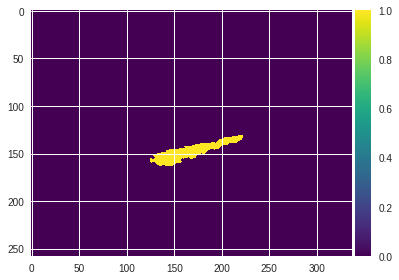

Added none


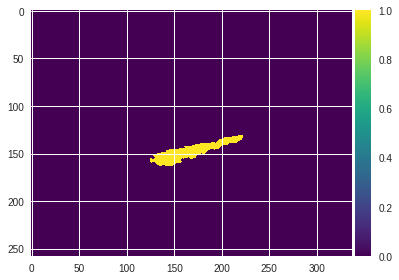

Added none


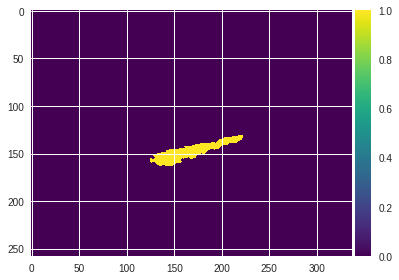

Added none


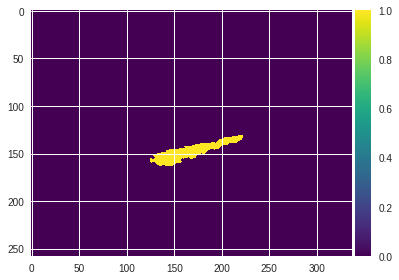

Added none


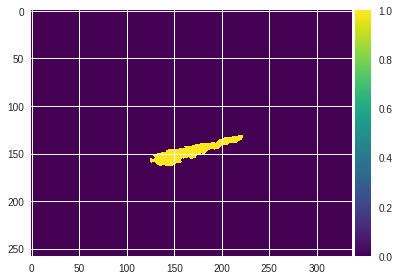

Added none


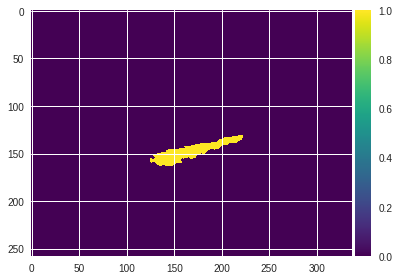

Added none


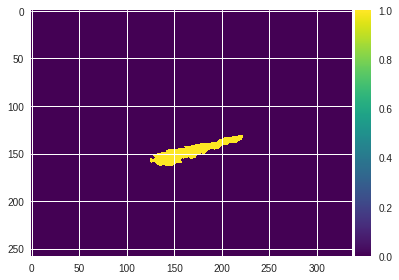

Added none


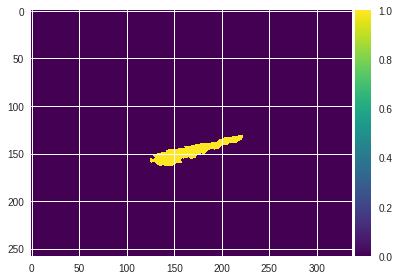

Added none


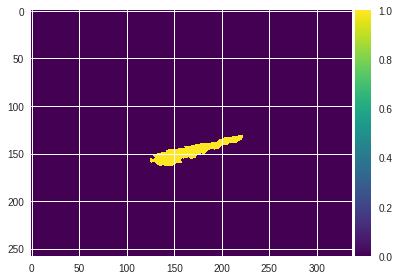

Added none


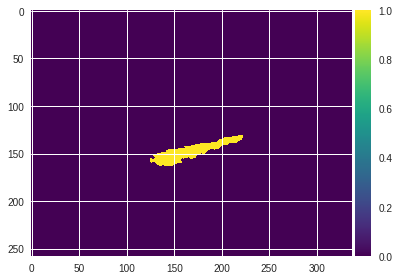

Added none


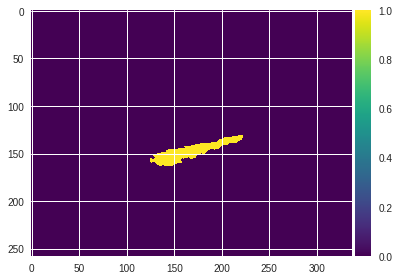

Added none


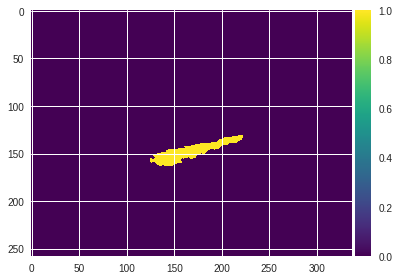

Added none


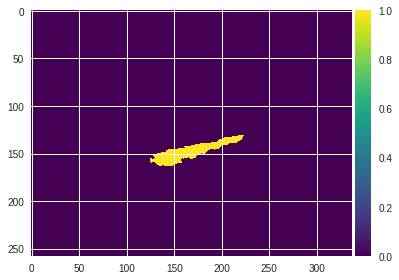

Added none


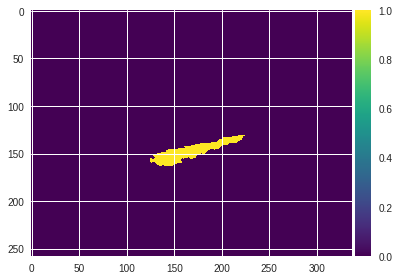

Added none


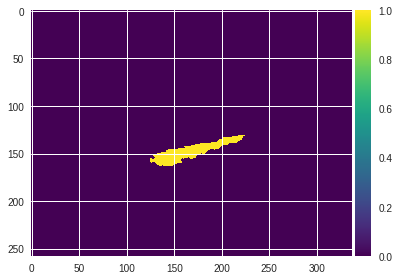

[0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 0, 1, 2, 7, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 10, 1, 1, 4, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0, 1, 0, 0, 2, 2, 1]


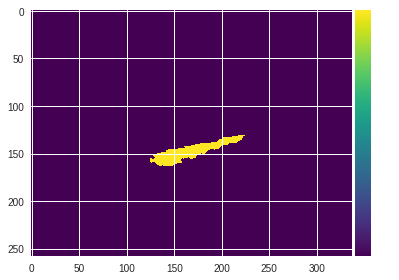

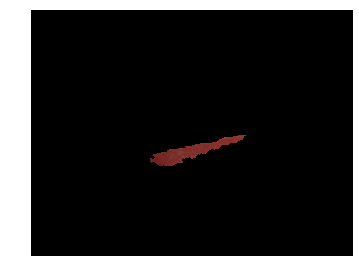

In [12]:
msMask = np.array(finMaskEroded).astype(int)
prev_msMask = np.array(msMask)

filteredImage = denoise_bilateral(originalImage,sigma_color=0.04,
                                  sigma_spatial=2,multichannel=True)
ybrImage = color.rgb2ycbcr(filteredImage)

cb = ybrImage[:,:,1]
cr = ybrImage[:,:,2]

io.imshow(cb)
plt.show()

io.imshow(cr)
plt.show()

def similar_colours(a,b):
  
  mncb = (cb[:,:])[msMask==1].mean()
  mncr = (cr[:,:])[msMask==1].mean()

  #if ybrImage[:,:,0][a]-mn < thresh:
  #print(cb[:,:][a]-cb[:,:][b])
  #print(np.abs(cb[:,:][a]-cb[:,:][b]) + np.abs(cr[:,:][a]-cr[:,:][b]))
  if np.abs(cb[:,:][a]-cb[:,:][b]) + np.abs(cr[:,:][a]-cr[:,:][b]) <= thresh:
    return True
  return False

thresh = 0.001
add = 0
ls = []
ls2 = []

cont = 0

while True:
  
  # calculating sd of ms, ml
  x,y = np.where(msMask==1)
  ms_sd = ybrImage[x,y,0].std()
  
  x,y = np.where((cosineImage * (1-msMask))==1)
  ml_sd = ybrImage[x,y,0].std()
  
  ls2.append(ml_sd - ms_sd)
  
  #print(ml_sd - ms_sd)
  if ml_sd <= ms_sd:
    msMask = np.array(prev_msMask)
    break
    
  # region growing
  prev_msMask = np.array(msMask)
  added = 0
  
  xL, yL = np.where(msMask==1)
  for i in range(len(xL)):
    for j in neighbours:
      x,y = xL[i] + j[0], yL[i] + j[1]
      if x<0 or y<0 or x>=imx or y>=imy or msMask[x,y] == 1 or cosineImage[x,y] == 0:
        continue
      if similar_colours((x,y), (xL[i],yL[i])):
        msMask[x,y] = 1
        added += 1
  
  add += added

  if added == 0:
    ls.append(add)    
    add = 0
    print("Added none")
    thresh += 0.005
    io.imshow(msMask)
    plt.show()
    cont += 1
    
  else:
    cont = 0
    
  if cont == 50:
    break

print(ls)
### Display part
io.imshow(msMask,vmin=0,vmax=1)
plt.axis('off')
plt.show()

newIm = np.array(originalImage)
for i in range(3):
  newIm[:,:,i] = originalImage[:,:,i] * msMask
plt.axis('off')
io.imshow(newIm)
plt.savefig('1.png')
plt.show()

In [0]:
temp = np.array(msMask).astype(int)

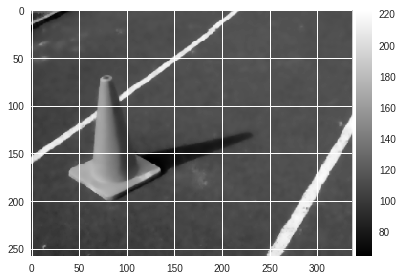

Added none
0.15494408781042157


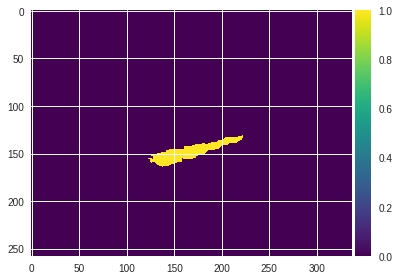

Added none
0.14135593060191276


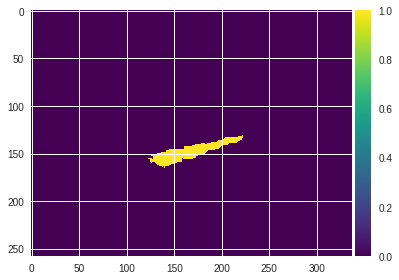

Added none
0.12749607317006006


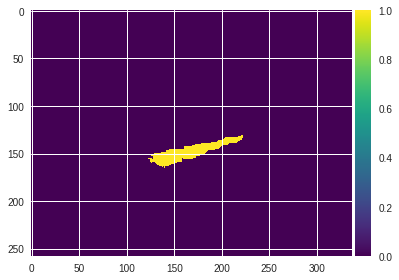

Added none
0.0030288008861578675


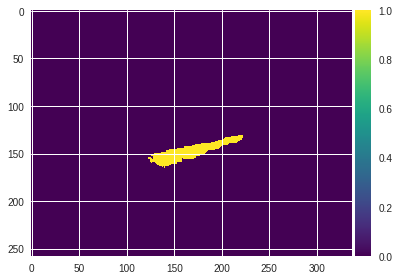

[38, 7, 10, 29]


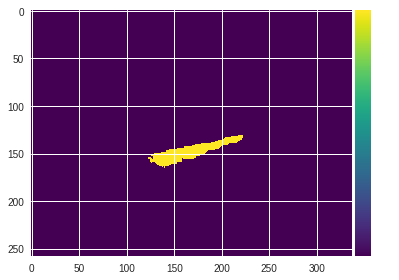

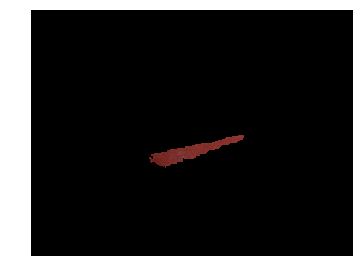

In [14]:
msMask = np.array(finMaskEroded).astype(int)
prev_msMask = np.array(msMask)
ybrImage = color.rgb2ycbcr(filteredImage)

io.imshow(ybrImage[:,:,0],cmap="gray")
plt.show()

def similar_colours(a,b):
  
  mn = (ybrImage[:,:,0])[msMask==1].mean()

  #if ybrImage[:,:,0][a]-mn < thresh:
  if ybrImage[:,:,0][a]-ybrImage[:,:,0][b] < thresh:
    return True
  return False

thresh = 0
add = 0
ls = []
ls2 = []

cont = 0

while True:
  
  # calculating sd of ms, ml
  x,y = np.where(msMask==1)
  ms_sd = ybrImage[x,y,0].std()
  
  x,y = np.where((cosineImage * (1-msMask))==1)
  ml_sd = ybrImage[x,y,0].std()
  
  ls2.append(ml_sd - ms_sd)
  
  #print(ml_sd - ms_sd)
  if ml_sd <= ms_sd:
    msMask = np.array(prev_msMask)
    break
    
  # region growing
  prev_msMask = np.array(msMask)
  added = 0
  
  xL, yL = np.where(msMask==1)
  for i in range(len(xL)):
    for j in neighbours:
      x,y = xL[i] + j[0], yL[i] + j[1]
      if x<0 or y<0 or x>=imx or y>=imy or msMask[x,y] == 1 or cosineImage[x,y] == 0:
        continue
      if similar_colours((x,y), (xL[i],yL[i])):
        msMask[x,y] = 1
        added += 1
  
  add += added

  if added == 0:
    ls.append(add)    
    add = 0
    print("Added none")
    print(ml_sd - ms_sd)
    thresh += 0.2
    io.imshow(msMask)
    plt.show()
    cont += 1
    
  else:
    cont = 0
    
  if cont >= 10:
    break

print(ls)
### Display part
io.imshow(msMask,vmin=0,vmax=1)
plt.axis('off')
plt.show()    

newIm = np.array(originalImage)
for i in range(3):
  newIm[:,:,i] = originalImage[:,:,i] * msMask
plt.axis('off')
io.imshow(newIm)
plt.savefig('1.png')
plt.show()

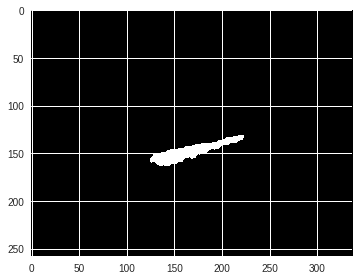

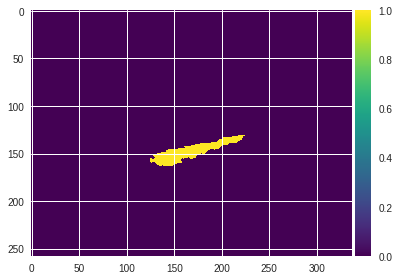

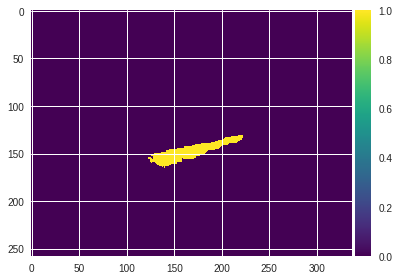

In [15]:
disk = morph.disk(2)
tm = morph.binary_closing(msMask, disk) * morph.binary_closing(temp, disk)
io.imshow(tm)
plt.show()
io.imshow(temp)
plt.show()
io.imshow(msMask)
plt.show()

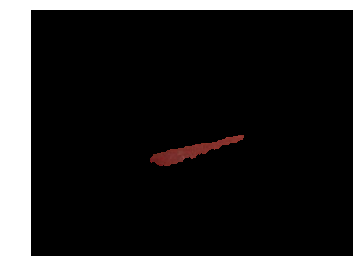

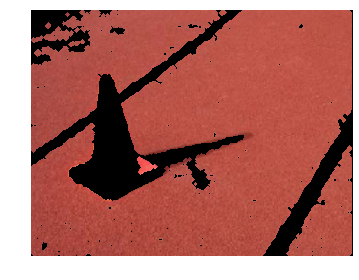

In [18]:
disk = morph.disk(2)
msMask_n = morph.binary_closing(tm, disk)
#msMask_n = tm

mlMask_n = cosineImage * (1-msMask_n)
mlMask_n = morph.binary_opening(mlMask_n, disk)

# Display
tmp = np.array(originalImage)
for i in range(3):
  tmp[:,:,i] = msMask_n * tmp[:,:,i]
io.imshow(tmp)
plt.axis('off')
plt.show()

tmp = np.array(originalImage)
for i in range(3):
  tmp[:,:,i] = mlMask_n * tmp[:,:,i]
io.imshow(tmp)
plt.axis('off')
plt.show()

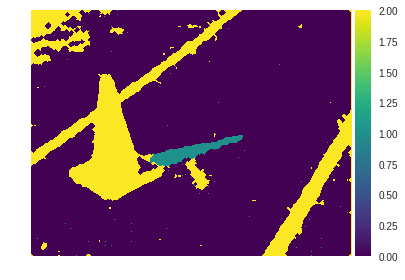

In [20]:
trimap = np.zeros(cosineImage.shape)
# 0:not shadow 1:shadow 2:rest
trimap[mlMask_n==1] = 1
trimap[msMask_n==1] = 1

def traverse(x,y,nm):
  Q = queue.Queue(100000)
  Q.put((x,y))
  if nm == 3:
    trimap[x,y] = 3
  
  while not Q.empty():
    x,y = Q.get()
    
    for j in neighbours:
      xn, yn = x + j[0], y + j[1]
      if xn<0 or xn>=imx or yn<0 or yn>=imy:
        continue
      if nm == 3 and mlMask_n[xn,yn] == 1:
        return 0
      if trimap[xn,yn] == 1:
        continue
      if nm == 3:
        if trimap[xn,yn] == 3:
          continue
        Q.put((xn,yn))
        trimap[xn,yn] = 3
      else:
        if trimap[xn,yn] == -1:
          continue
        Q.put((xn,yn))
        trimap[xn,yn] = -1
      
  return 1      
    

# initial: no ml around 3, else -1
for i in range(originalImage.shape[0]):
  for j in range(originalImage.shape[1]):
    if trimap[i,j] == 0:
      ret = traverse(i,j,3)
      if ret==0:
        traverse(i,j,-1)

trimap[mlMask_n==1] = 0
trimap[trimap==3] = 1
trimap[trimap==-1] = 2

# Display purposes        
plt.axis('off')
io.imshow(trimap)
plt.show()

### Image Matting to compute $M_{shadow}$

Possible Issues:

- Might have to reduce the disk size back to 1 in previous step, and count number of bordering $M_l$ and $M_s$ pixels instead.

- Improve `trimap` calculation

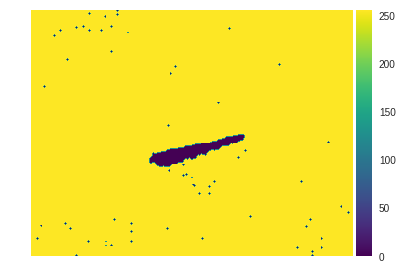

In [21]:
trimap[trimap!=1] = 0
temp = np.array(trimap)
disk = morph.disk(1)
temp = morph.binary_dilation(temp, disk)
trimap[temp==0] = 255
trimap[trimap==0] = 128
trimap[trimap==1] = 0

plt.axis('off')
io.imshow(trimap)
plt.savefig('1.png',dip=100)
plt.show()

Credits to https://github.com/MarcoForte/mishima-matting/

In [0]:
# Get fg/bg distances for each pixel from each surface on convex hull
def convex_hull_distance(cvx_hull, pixels):
    d_hull = np.ones(pixels.shape[0]*cvx_hull.equations.shape[0]).reshape(pixels.shape[0],cvx_hull.equations.shape[0])*1000
    for j, surface_eq in enumerate(cvx_hull.equations):
        for i, px_val in enumerate(pixels):
            nhat= surface_eq[:3]
            d_hull[i,j] = np.dot(nhat, px_val) + surface_eq[3]
    return  np.maximum(np.amax(d_hull, axis=1),0)

def mishima_matte(img, trimap):
    h,w,c = img.shape
    bg = trimap == 0
    fg = trimap == 255
    unknown = True ^ np.logical_or(fg,bg)
    fg_px = img[fg]
    bg_px = img[bg]
    unknown_px = img[unknown]

    # Setup convex hulls for fg & bg
    fg_hull = scipy.spatial.ConvexHull(fg_px)
    fg_vertices_px = fg_px[fg_hull.vertices]
    bg_hull = scipy.spatial.ConvexHull(bg_px)
    bg_vertices_px = bg_px[bg_hull.vertices]

    # Compute shortest distance for each pixel to the fg&bg convex hulls
    d_fg = convex_hull_distance(fg_hull, unknown_px)
    d_bg = convex_hull_distance(bg_hull, unknown_px)

    # Compute uknown region alphas and add to known fg.
    alphaPartial = d_bg/(d_bg+d_fg)
    alpha = unknown.astype(float).copy()
    alpha[alpha !=0] = alphaPartial
    alpha = alpha + fg
    return alpha

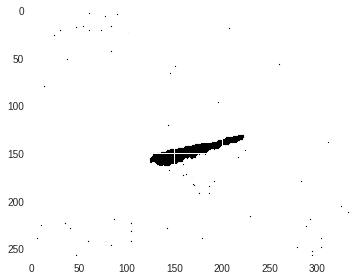

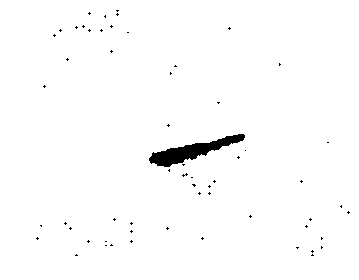

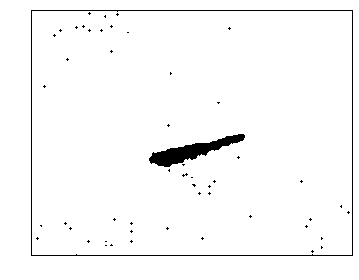

In [24]:
alpha = mishima_matte(originalImage.astype(float), trimap.astype(float))

##Display
io.imshow(alpha)
plt.show()
##

alpha[alpha>0.5] = 1
alpha[alpha!=1] = 0

##Display
io.imshow(alpha)
plt.axis('off')
plt.show()

disk = morph.disk(1)
alpha = morph.binary_closing(alpha, disk)

##Display 
plt.axis('off')
io.imshow(alpha)
plt.show()

In [0]:
from google.colab import files
for i in range(10):
  files.download(str(i+1)+'.png')